# Курсовая работа № 2
## Data Scientist. Аналитика

Курсовая работа состоит из двух частей – обязательной и дополнительной. **Для зачета необходимо выполнение только первой части.** Выполнение второй части может потребовать дополнительные знания Python.

- [Часть первая](#Часть-первая)
- [Часть вторая](#Часть-вторая)

## Часть первая


Перед вами стоит задача – подготовить аналитический отчет для HR-отдела. На основании проведенной аналитики предполагается составить рекомендации для отдела кадров по стратегии набора персонала, а также по взаимодействию с уже имеющимися сотрудниками.
<br><br> В базе данных лежит набор таблиц, которые содержат данные о сотрудниках вымышленной компании.
Сделайте обзор штата сотрудников компании. Составьте набор предметов исследования, а затем проверьте их на данных. Вся аналитика должна быть выполена с помощью SQL. Впоследствии данные можно визуализировать, однако финальные датафреймы для графиков также должны быть подготовлены с помощью SQL.

In [1]:
# Импорт библиотек Psycopg2, Numpy, Pandas
import psycopg2
import numpy as np
import pandas as pd

# Подключение к базе данных PostgreSQL
conn = psycopg2.connect(**{'host': 'dsstudents.skillbox.ru', 
                           'port': 5432, 
                           'dbname': 'human_resources', 
                           'user': 'readonly', 
                           'password': '6hajV34RTQfmxhS'})

In [2]:
# Получение информации о структуре таблицы hr_dataset
hr_df = pd.read_sql_query('select * from hr_dataset', conn).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   310 non-null    int64  
 1   Employee Name        310 non-null    object 
 2   Employee Number      310 non-null    int64  
 3   marriedid            310 non-null    int64  
 4   maritalstatusid      310 non-null    int64  
 5   genderid             310 non-null    int64  
 6   empstatus_id         310 non-null    int64  
 7   deptid               310 non-null    int64  
 8   perf_scoreid         310 non-null    int64  
 9   age                  310 non-null    int64  
 10  Pay Rate             310 non-null    float64
 11  state                310 non-null    object 
 12  zip                  310 non-null    int64  
 13  dob                  310 non-null    object 
 14  sex                  310 non-null    object 
 15  maritaldesc          310 non-null    obj

In [3]:
# Получение информации о структуре таблицы production_staff
pd.read_sql_query('select * from production_staff', conn).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   256 non-null    int64  
 1   Employee Name        209 non-null    object 
 2   Race Desc            209 non-null    object 
 3   Date of Hire         209 non-null    object 
 4   TermDate             83 non-null     object 
 5   Reason for Term      209 non-null    object 
 6   Employment Status    209 non-null    object 
 7   Department           209 non-null    object 
 8   Position             209 non-null    object 
 9   Pay                  209 non-null    object 
 10  Manager Name         209 non-null    object 
 11  Performance Score    209 non-null    object 
 12  Abutments/Hour Wk 1  208 non-null    float64
 13  Abutments/Hour Wk 2  208 non-null    float64
 14  Daily Error Rate     208 non-null    float64
 15  90-day Complaints    208 non-null    flo

In [4]:
# Получение информации о структуре таблицы recruiting_cost
pd.read_sql_query('select * from recruiting_costs', conn).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 22 non-null     int64 
 1   Employment Source  22 non-null     object
 2   January            22 non-null     int64 
 3   February           22 non-null     int64 
 4   March              22 non-null     int64 
 5   April              22 non-null     int64 
 6   May                22 non-null     int64 
 7   June               22 non-null     int64 
 8   July               22 non-null     int64 
 9   August             22 non-null     int64 
 10  September          22 non-null     int64 
 11  October            22 non-null     int64 
 12  November           22 non-null     int64 
 13  December           22 non-null     int64 
 14  Total              22 non-null     int64 
dtypes: int64(14), object(1)
memory usage: 2.7+ KB


In [5]:
# Получение информации о структуре таблицы salary_grid
pd.read_sql_query("select * from salary_grid", conn).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          12 non-null     int64  
 1   Position    12 non-null     object 
 2   Salary Min  12 non-null     int64  
 3   Salary Mid  12 non-null     int64  
 4   Salary Max  12 non-null     int64  
 5   Hourly Min  12 non-null     float64
 6   Hourly Mid  12 non-null     float64
 7   Hourly Max  12 non-null     float64
dtypes: float64(3), int64(4), object(1)
memory usage: 896.0+ bytes


### Исследование 1. Возраст сотрудника влияет на качество его работы. Возрастные сотрудники в работе допускают больше ошибок.

In [6]:
# Получение из базы данных информации по сотрудникам компании
sql_query = '''
    select hr.age, pr."Daily Error Rate" as daily_error_rate
    from hr_dataset hr 
    left join production_staff pr on 
        (hr."Employee Name" = pr."Employee Name") and (hr."Date of Hire" = pr."Date of Hire") and 
        (hr.position = pr."Position")'''

staff_df = pd.read_sql_query(sql_query, conn).fillna(0)

# Определение возрастных групп сотрудников компании
age_range = pd.cut(staff_df['age'], [0, 30, 50, 80])

# Вывод среднего числа ежедневных ошибок, приходящееся на каждого сотрудника для каждой возрастной группы
staff_df.pivot_table(values='daily_error_rate', index=age_range, aggfunc=np.mean)

,daily_error_rate
age,
"(0, 30]",0.372549
"(30, 50]",0.638393
"(50, 80]",0.714286


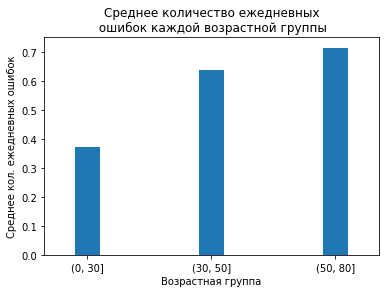

In [7]:
# Переход в интерактивный режим построения графиков и диаграмм
%matplotlib inline

# Импорт библиотеки Matplotlib
import matplotlib.pyplot as plt

# Определение основных объектов диаграммы
fig, ax = plt.subplots(figsize=(6, 4))

# Отражение среднего количества ежедневных ошибок каждой возрастной группы
staff_df.pivot_table(values='daily_error_rate', index=age_range, aggfunc=np.mean).plot.bar(
    ax=ax, width=0.2, title='Среднее количество ежедневных\n ошибок каждой возрастной группы', rot=0, legend=None)

# Вывод подписей осей координат
ax.set_xlabel('Возрастная группа')
ax.set_ylabel('Среднее кол. ежедневных ошибок')

# Отображение диаграмм на странице
plt.show()

### Исследование 2. Сотрудники среднего возраста - самые высокооплачиваемые сотрудники

In [8]:
# Получение из базы данных информации по сотрудникам компании
sql_query = 'select age, "Pay Rate" as pay_rate from hr_dataset'
staff_df = pd.read_sql_query(sql_query, conn).fillna(0)

# Вывод медианы оплаты труда сотрудников для каждой возрастной группы
staff_df.pivot_table(values='pay_rate', index=age_range, aggfunc=np.median)

,pay_rate
age,
"(0, 30]",28.00
"(30, 50]",23.25
"(50, 80]",26.00


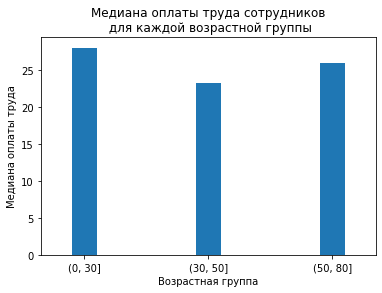

In [9]:
# Определение основных объектов диаграммы
fig, ax = plt.subplots(figsize=(6, 4))

# Отражение медианы оплаты труда сотрудников для каждой возрастной группы
staff_df.pivot_table(values='pay_rate', index=age_range, aggfunc=np.median).plot.bar(
    ax=ax, width=0.2, title='Медиана оплаты труда сотрудников\n для каждой возрастной группы', rot=0, legend=None)

# Вывод подписей осей координат
ax.set_xlabel('Возрастная группа')
ax.set_ylabel('Медиана оплаты труда')

# Отображение диаграмм на странице
plt.show()

### Исследование 3. Сотрудники молодого возраста больше подвержены частой смене работы

In [10]:
# Получение из базы данных информации по сотрудникам компании
sql_query = 'select age, "Days Employed" as days_employed from hr_dataset'
staff_df = pd.read_sql_query(sql_query, conn).fillna(0)

# Вывод медианы длительности работы сотрудника в компании для каждой возрастной группы
staff_df.pivot_table(values='days_employed', index=age_range, aggfunc=np.median)

,days_employed
age,
"(0, 30]",1112
"(30, 50]",1291
"(50, 80]",1238


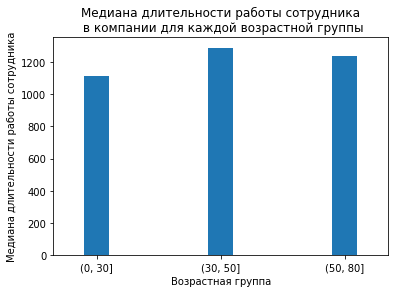

In [11]:
# Определение основных объектов диаграммы
fig, ax = plt.subplots(figsize=(6, 4))

# Отражение медианы длительности работы сотрудника в компании для каждой возрастной группы
staff_df.pivot_table(values='days_employed', index=age_range, aggfunc=np.median).plot.bar(
    ax=ax, width=0.2, title='Медиана длительности работы сотрудника\n в компании для каждой возрастной группы', 
    rot=0, legend=None)

# Вывод подписей осей координат
ax.set_xlabel('Возрастная группа')
ax.set_ylabel('Медиана длительности работы сотрудника')

# Отображение диаграмм на странице
plt.show()

### Исследование 4. Иммигранты и неграждане страны менее добросовестно выполняют свою работу

In [12]:
# Получение из базы данных информации по сотрудникам компании
sql_query = '''
    select hr.citizendesc, pr."Daily Error Rate" as daily_error_rate
    from hr_dataset hr 
    left join production_staff pr on 
        (hr."Employee Name" = pr."Employee Name") and (hr."Date of Hire" = pr."Date of Hire") and 
        (hr.position = pr."Position")'''

staff_df = pd.read_sql_query(sql_query, conn).fillna(0)

# Вывод среднего числа ежедневных ошибок у групп сотрудников из категории "citizendesc"
staff_df.pivot_table(values='daily_error_rate', index='citizendesc', aggfunc=np.mean)

,daily_error_rate
citizendesc,
Eligible NonCitizen,0.750000
Non-Citizen,1.250000
US Citizen,0.588435


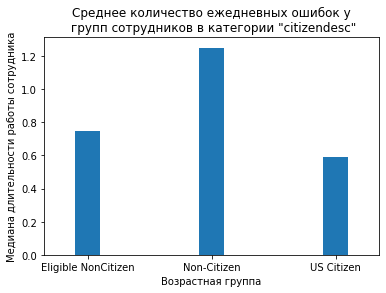

In [13]:
# Определение основных объектов диаграммы
fig, ax = plt.subplots(figsize=(6, 4))

# Отражение среднего числа ежедневных ошибок у групп сотрудников из категории "citizendesc"
staff_df.pivot_table(values='daily_error_rate', index='citizendesc', aggfunc=np.mean).plot.bar(
    ax=ax, width=0.2, title='Среднее количество ежедневных ошибок у\n групп сотрудников в категории "citizendesc"', 
    rot=0, legend=None)

# Вывод подписей осей координат
ax.set_xlabel('Возрастная группа')
ax.set_ylabel('Медиана длительности работы сотрудника')

# Отображение диаграмм на странице
plt.show()

### Вывод

Все рассмотренные гипотезы подтвердились, кроме одной - "*Сотрудники среднего возраста - самые высокооплачиваемые сотрудники*". Согласно проведенного анализа по данной гипотезе, наибольший заработок получают сотрудники из возрастной группы не старше 30.

В качестве рекомендации по стратегии набора персонала, можно рекомендовать следующий портрет идеального сотрудника:
1. согласно гипотезам 1-3, сотрудник должен быть из группы среднего возраста (от 30 до 50), так как в работе допускает количество ежедневных ошибок в пределах среднего, получает наименьший заработок и меньше всего подвержен частым сменам работы;
2. согласно гипотезе 4, сотрудник должен быть гражданином Соединенных Штатов Америки, так как более добросовестно выполняет работу и меньше допускает ежедневных ошибок.

## Часть вторая

Перед вами стоит задача – подготовить аналитический ответ для SMM-отдела компании Skillbox. <br> Объектом анализа является  [паблик Skillbox Вконтакте](https://vk.com/skillbox_education). <br> <br> 
Подключитесь к  API VK и выгрузите посты со стены паблика Skillbox за интересующий период (определите самостоятельно и обоснуйте). Проанализируйте влияние различных факторов (например, времени публикации) на вовлеченность пользователей (количество лайков, комментариев, голосов в опросах). Сделайте аналитику по рубрикам (примеры рубрик: дизайн-битва, игра по управлению), которые есть в паблике. Выбрать нужные посты можно с помощью регулярных выражений. Составьте перечень рекомандаций для SMM-отдела по итогам анализа.

In [14]:
# Импорт библиотек Math, Requests, Numpy и Pandas
import math
import requests
import numpy as np
import pandas as pd

# Импорт библиотеки DateTime
from datetime import datetime

# Определение основных параметров запроса
url = 'https://api.vk.com/method/wall.get'
token = '72dcb67872dcb67872dcb6785b72ae8662772dc72dcb6782c1740804e0b1207aa8a90ff'
domain = 'skillbox_education'
version = 5.107
offset = 0

# Получение количества постов на стене паблика Skillbox
response = requests.get(url, params={'access_token': token, 'v': version, 'domain': domain, 'count': 1})
count_posts = response.json()['response']['count']

# Получение всех постов стены паблика Skillbox
all_posts = list()

while offset <= math.ceil(count_posts / 100) * 100:
    response = requests.get(url, params={'access_token': token, 'v': version, 'domain': domain, 'count': 100, 'offset': offset})
    all_posts.extend(response.json()['response']['items'])
    offset += 100

# Формирование датасета с выгруженными постами 
posts_df = pd.json_normalize(all_posts)

# Преобразование значений в колонке 'date' в формат даты
posts_df['date'] = posts_df['date'].apply(datetime.fromtimestamp)

# Преобразование текста в колонке 'text' к нижнему регистру
posts_df['text'] = posts_df['text'].str.lower()

### Анализ влияния различных факторов (например, времени публикации) на вовлеченность пользователей (количество лайков, комментариев, голосов в опросах)

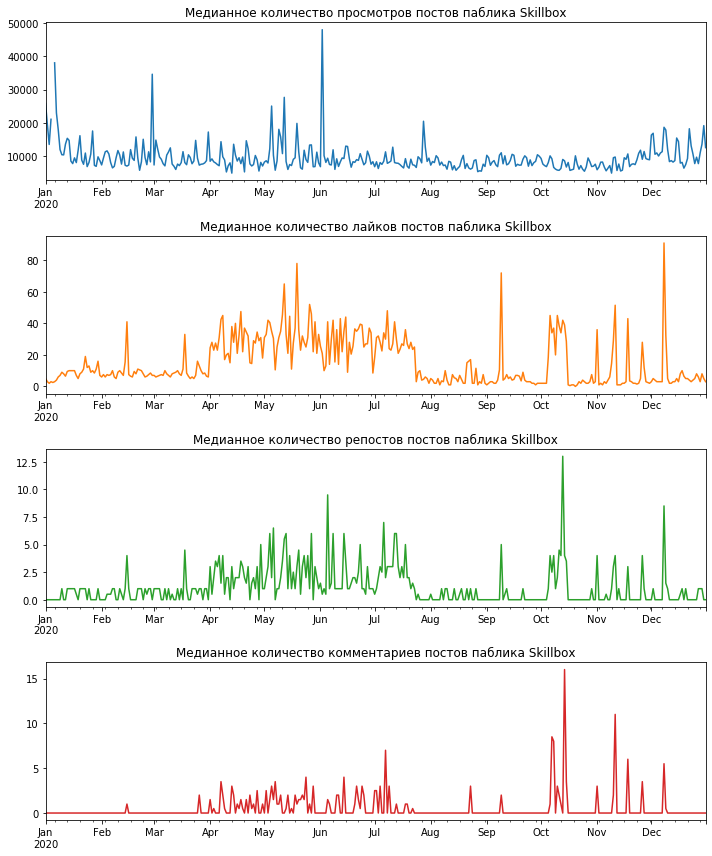

In [15]:
# Определение основных объектов диаграммы
fig, axes = plt.subplots(4, 1, figsize=(10, 12))

# Формирование датасета для построения графиков
chart_df = posts_df.pivot_table(
    values=['views.count', 'likes.count', 'reposts.count', 'comments.count'], 
    index=pd.to_datetime(10000 * 2020 + 100 * posts_df.date.dt.month + posts_df.date.dt.day, format='%Y%m%d'), 
    aggfunc=np.median)

# Словарь заголовков
titles = {'views': 'Медианное количество просмотров постов паблика Skillbox',
          'likes':'Медианное количество лайков постов паблика Skillbox', 
          'reposts': 'Медианное количество репостов постов паблика Skillbox', 
          'comments': 'Медианное количество комментариев постов паблика Skillbox'}

# Вывод графиков на страницу
chart_df['views.count'].plot(ax=axes[0], color='tab:blue', title = titles['views'])
chart_df['likes.count'].plot(ax=axes[1], color='tab:orange', title = titles['likes'])
chart_df['reposts.count'].plot(ax=axes[2], color='tab:green', title = titles['reposts'])
chart_df['comments.count'].plot(ax=axes[3], color='tab:red', title = titles['comments'])

# Подписание осей координат
for ax in axes.flat:
    ax.set(xlabel=None, ylabel=None)

# Автоматическое позиционирование элементов графика
fig.tight_layout()

# Отображение графика на странице
plt.show()

### Вывод

На графиках, отражающих вовлеченность, пользователей в различные периоды времени календарного года видно, что в периоды с апреля по июль и с октября по декабрь пользователи проявляют наибольший интерес к опубликованному материалу на стене паблика Skillbox. В весенне-летний период наблюдается не только высокий, но и стабильный интерес к постам паблика Skillbox.

### Анализ по рубрикам (примеры рубрик: дизайн-битва, игра по управлению), которые есть в паблике

#### Вывод самых публикуемых рубрик паблика Skillbox

In [16]:
# Импорт модуля регулярных выражений
import re

# Формирование полного списка рубрик
rubric_list = posts_df['text'].str.findall('#\w+').apply(lambda x: ','.join(x)).to_list()
rubric_list = ','.join(rubric_list).split(',')

# Формирование датасета рубрик
rubric_df = pd.DataFrame({'rubric': rubric_list, 'count': 1})

# Удаление из датасета пустых позиций
rubric_df = rubric_df.query('rubric!=""')

# Вывод 10 популярных рубрик
rubric_df.groupby('rubric').count().sort_values('count', ascending=False).head(10)

,count
rubric,
#цитаты,768
#афоризмы,764
#read,370
#skillbox,359
#business,319
#skillbox_дизайн,203
#marketing,202
#design,198
#code,190


#### Анализ постов из рубрики "skillbox_дизайн"

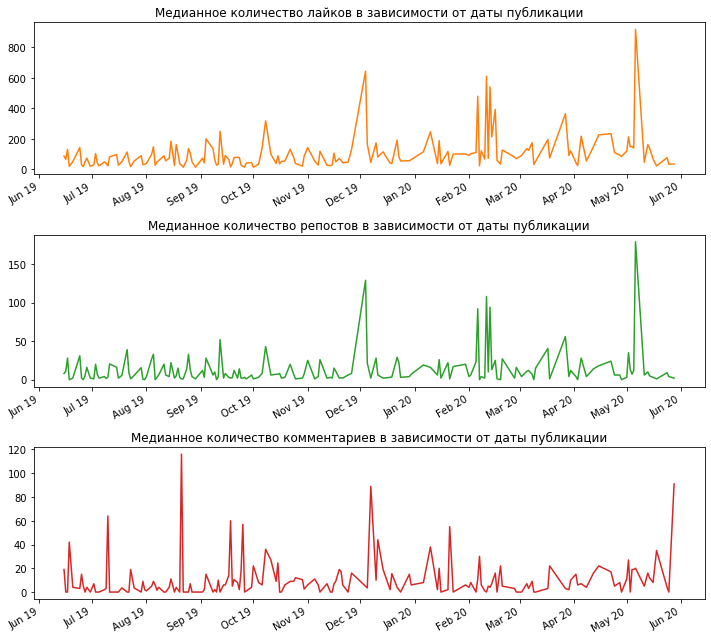

In [17]:
# Импорт модуля Dates пакета Matplotlib
import matplotlib.dates as mdates

# Определение основных объектов диаграммы
fig, axes = plt.subplots(3, 1, figsize=(10, 9))

# Формирование датасета для построения графика
index_list = posts_df['text'].str.contains('#skillbox_дизайн')

chart_df = posts_df[index_list].pivot_table(
    values=['likes.count', 'reposts.count', 'comments.count'],
    index=posts_df['date'].astype('datetime64[D]'), 
    aggfunc=np.median)

# Словарь заголовков
titles = {'likes':'Медианное количество лайков в зависимости от даты публикации', 
          'reposts': 'Медианное количество репостов в зависимости от даты публикации', 
          'comments': 'Медианное количество комментариев в зависимости от даты публикации'}

# Вывод графиков на страницу
chart_df['likes.count'].plot(ax=axes[0], color='tab:orange', title=titles['likes'])
chart_df['reposts.count'].plot(ax=axes[1], color='tab:green', title=titles['reposts'])
chart_df['comments.count'].plot(ax=axes[2], color='tab:red', title=titles['comments'])

# Определение формата меток осей
for ax in axes.flat:
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))

# Подписание осей координат
for ax in axes.flat:
    ax.set(xlabel=None, ylabel=None)

# Автоматическое позиционирование элементов графика
fig.tight_layout()

# Отображение графика на странице
plt.show()

In [18]:
# Вывод постов вызвавшие наибольший интерес в Декабре месяце
month_df = posts_df[['date', 'text', 'likes.count', 'reposts.count', 'comments.count']]
month_df = month_df.query('date > "2019.11.25" & date < "2019.12.10"')
month_df = month_df[month_df['text'].str.contains('#skillbox_дизайн')]

# Вывод постов
month_df

,date,text,likes.count,reposts.count,comments.count
301,2019-12-07 11:00:01,студия warner bros. часто адаптирует свой лого...,46,2,89
305,2019-12-05 17:00:10,"создать или скачать — вот в чем вопрос. да-да,...",69,11,4
306,2019-12-05 12:22:09,"ко дню рождения уолта диснея, «отца» микки мау...",262,32,3
307,2019-12-04 19:00:01,"дизайнеры, отвлекитесь от игр со шрифтами. лов...",643,129,5
327,2019-11-26 11:43:14,если давно хотели научиться рисовать в стиле p...,129,8,16


In [19]:
# Вывод текста поста с наибольшим количеством лайков
month_df['text'][month_df['likes.count'].idxmax()]

'дизайнеры, отвлекитесь от игр со шрифтами. ловите подборку из семи фильмов и сериалов, которые расширят ваш профессиональный кругозор.\n\n#в_закладки_skillbox #skillbox_дизайн'

In [20]:
# Вывод постов вызвавшие наибольший интерес в Феврале месяце
month_df = posts_df[['date', 'text', 'likes.count', 'reposts.count', 'comments.count']]
month_df = month_df.query('date > "2020.02.05" & date < "2020.02.15"')
month_df = month_df[month_df['text'].str.contains('#skillbox_дизайн')]

# Вывод постов
month_df

,date,text,likes.count,reposts.count,comments.count
174,2020-02-14 11:21:30,"быть частью целого, но оставаться собой😏 apple...",213,13,7
176,2020-02-13 11:59:51,"дизайнеры, собрали для вас сайты, где можно бе...",540,94,4
177,2020-02-12 18:46:18,"точка, точка, запятая, – вышла рожица кривая. ...",72,10,5
181,2020-02-11 12:22:05,"нужна картинка для соцсетей, а photoshop нет п...",610,108,0
183,2020-02-10 16:53:20,"сегодня не бульварное чтиво в моде, а мода в б...",68,2,1
187,2020-02-08 14:28:34,у талантливого дизайнера даже самые страшные м...,122,4,6
188,2020-02-07 12:31:03,"евровидение меняет логотип каждый год, но на э...",24,0,30
192,2020-02-06 11:31:11,на вкус и цвет товарища нет? насчет вкуса согл...,479,92,11
193,2020-02-05 19:11:06,не можете определиться с цветовой палитрой для...,110,23,0


In [21]:
# Вывод текста поста с наибольшим количеством лайков
month_df['text'][month_df['likes.count'].idxmax()]

'нужна картинка для соцсетей, а photoshop нет под рукой? воспользуйтесь бесплатными сервисами по созданию изображений. не ищите, мы уже все собрали для вас.\n\ncanva. в вашем распоряжении миллионы фотографий, векторных изображений и иллюстраций, сотни шрифтов, множество иконок и фильтров. создавайте картинки для любых целей. соцсети, обложки для блогов и книг, открытки, инфографика, ресторанное меню — canva может почти все.\n\ncrello. здесь можно работать не только со статичными изображениями, но даже с анимацией. не нравятся имеющиеся шрифты? загрузите свои, в этом нет никаких ограничений. кстати, для вашего вдохновения собрана целая галерея готовых работ.\n\nadobe spark. в сервисе есть готовые шаблоны, по которым очень удобно работать. ничего, если у вас нет опыта в дизайне: adobe spark на каждом шагу дает подсказки.\n\ngiphy gif maker. простой и удобный сервис для создания гифок. перед началом работы необязательно скачивать видео: достаточно дать на него ссылку. к гифке можно добави

In [22]:
# Вывод постов вызвавшие наибольший интерес в Мае месяце
month_df = posts_df[['date', 'text', 'likes.count', 'reposts.count', 'comments.count']]
month_df = month_df.query('date > "2020.05.01" & date < "2020.05.15"')
month_df = month_df[month_df['text'].str.contains('#skillbox_дизайн')]

# Вывод постов
month_df

,date,text,likes.count,reposts.count,comments.count
21,2020-05-14 11:55:07,когда внутренний мир вырывается наружу. \n\nма...,140,5,12
23,2020-05-13 12:08:31,"как бы выглядело вдохновение, если бы его визу...",162,10,16
26,2020-05-11 16:52:19,каждый вид искусства по-своему прекрасен. но в...,47,6,5
32,2020-05-06 12:20:16,"срочно нужна анимация в соцсети, а у дизайнера...",917,179,20
33,2020-05-05 12:30:12,как вам такой парадоксальный жанр: гиперреальн...,140,12,19
35,2020-05-04 11:34:37,да пребудут с вами скиллы! сегодня праздник у ...,150,7,19
36,2020-05-03 15:38:01,превратить стилус в кисти эдварда мунка? и так...,148,13,0
37,2020-05-02 16:05:33,самая большая сложность в ux-дизайне — объясни...,214,35,27
38,2020-05-01 13:58:50,мир! труд! май! дизайн!\n\nпраздник весны и тр...,120,3,11


In [23]:
# Вывод текста поста с наибольшим количеством лайков
month_df['text'][month_df['likes.count'].idxmax()]

'срочно нужна анимация в соцсети, а у дизайнера майские праздники?\n\nловите подборку сервисов, которые помогут «оживить» картинку, даже если вы не умеете рисовать. читайте в карточках!\n\n#в_закладки_skillbox #skillbox_дизайн'

### Вывод

Одна из самых публикуемых рубрик на паблике Skillbox - "#Skillbox_Дизайн" (203 публикации). Анализ вовлеченности пользователей по данной рубрике, за весь период ее публикации, показывает, что на Декабрь, Февраль и Май приходится наибольшая активность. Активность в Декабре обусловлена публикацией поста с подборкой из семи фильмов и сериалов, что получило наибольший отклик от пользователей. В Феврале активность пришлась на пост с бесплатными сервисами по созданию изображений, в Мае - пост с сервисами по "оживлению" картинок.

Из проведенного анализа по рубрике "#Skillbox_Дизайн" следует, что наибольшей популярностью среди пользователей пользуются посты с бесплатными и уникальными сервисами, а также посты с нестандартной подачей материала.

### Рекомандации для SMM-отдела

Учитывая сезонность интереса пользователей к информации, публикуемой на стене Skillbox, основную маркетинговую активность по продвижению курсов лучше планировать в весенне-летний период.

Также необходимо обратить внимание на подачу материала постов - нестандартная подача информации пользуется популярностью, например, видео материал. Среди пользователей популярны посты с хорошей практической ценностью - полезная информация, которую можно применить на практике и получить хороший результат.